# Camera trajectory optimization

<a href="https://colab.research.google.com/github/RuslanAgishev/frontier_exploration/blob/master/camera_traj_optimization_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# if you are using Colab:
# from google.colab import drive
# drive.mount('/content/drive/')
# FE_PATH = "drive/MyDrive/CTU/frontier_exploration/"

# if you are running locally
import rospkg
FE_PATH = rospkg.RosPack().get_path('frontier_exploration')

In [3]:
import os
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy

In [4]:
def load_intrinsics(device=torch.device('cuda')):
    width, height = 1232., 1616.
    K = torch.tensor([[758.03967, 0., 621.46572, 0.],
                      [0., 761.62359, 756.86402, 0.],
                      [0., 0., 1., 0.],
                      [0., 0., 0., 1.]], dtype=torch.float32).to(device)
    K = K.unsqueeze(0)
    return K, width, height

### Define model to optimize trajectory

In [5]:
class Model(nn.Module):
    def __init__(self,
                 points: torch.tensor,
                 traj_wps: list,  # [np.array([x0, y0, z0]), np.array([x1, y1, z1]), ...]
                 min_dist=1.0, max_dist=10.0,
                 dist_rewards_mean=3.0, dist_rewards_sigma=2.0):
        super().__init__()
        self.points = points
        self.rewards = None
        self.observations = None
        self.device = points.device
        self.lo_sum = 0.0  # log odds sum for the entire point cloud for the whole trajectory

        # Create an optimizable parameter for the x, y, z position of the camera.
        self.rot0 = torch.eye(3, device=self.device).unsqueeze(0)
        for i in range(len(traj_wps) - 1):
            self.rot0 = torch.cat([self.rot0, torch.eye(3, device=self.device).unsqueeze(0)])  # (N, 3, 3)
        self.traj0 = torch.from_numpy(np.array(traj_wps, dtype=np.float32)).to(self.device)  # (N, 3)

        self.traj = nn.Parameter(deepcopy(self.traj0))
        self.rots = nn.Parameter(self.rot0)

        self.K, self.width, self.height = load_intrinsics(device=self.device)
        self.eps = 1e-6
        self.pc_clip_limits = [min_dist, max_dist]  # [m]
        self.dist_rewards = {'mean': dist_rewards_mean, 'dist_rewards_sigma': dist_rewards_sigma}
        
        self.loss = {'vis': None, 'l2': None, 'vel': None, 'acc': None, 'jerk': None}

    @staticmethod
    def get_dist_mask(points, min_dist=1.0, max_dist=5.0):
        # clip points between MIN_DIST and MAX_DIST meters distance from the camera
        dist_mask = (points[2] > min_dist) & (points[2] < max_dist)
        return dist_mask

    @staticmethod
    def get_fov_mask(points, img_height, img_width, intrins):
        # find points that are observed by the camera (in its FOV)
        pts_homo = intrins[:3, :3] @ points
        pts_homo[:2] /= pts_homo[2:3]
        fov_mask = (pts_homo[2] > 0) & (pts_homo[0] > 1) & \
                   (pts_homo[0] < img_width - 1) & (pts_homo[1] > 1) & \
                   (pts_homo[1] < img_height - 1)
        return fov_mask

    def to_camera_frame(self, verts, R, T):
        R_inv = torch.transpose(torch.squeeze(R, 0), 0, 1)
        verts = torch.transpose(verts - torch.repeat_interleave(T, len(verts), dim=0).to(self.device), 0, 1)
        verts = torch.matmul(R_inv, verts)
        verts = torch.transpose(verts, 0, 1)
        return verts

    @staticmethod
    def gaussian(x, mu=3.0, sigma=100.0, normalize=False):
        # https://en.wikipedia.org/wiki/Normal_distribution
        g = torch.exp(-0.5 * ((x - mu) / sigma) ** 2)
        if normalize:
            g /= (sigma * torch.sqrt(torch.tensor(2 * np.pi)))
        return g

    def distance_visibility(self, verts, pose):
        # compute observations based on distance of the surrounding points
        dists = torch.linalg.norm(pose - verts, dim=1)
        rewards = self.gaussian(dists, mu=self.dist_rewards['mean'], sigma=self.dist_rewards['dist_rewards_sigma'])
        return rewards

    def forward(self):
        """
        Trajectory evaluation based on visibility estimation from its waypoints.
        traj_score = log_odds_sum([visibility_estimation(wp) for wp in traj_waypoints])
        """
        N_wps = self.traj.size()[0]
        lo_sum = 0.0
        for i in range(N_wps):
            # transform points to camera frame
            verts = self.to_camera_frame(self.points, self.rots[i].unsqueeze(0), self.traj[i].unsqueeze(0))
            verts = torch.transpose(verts, 0, 1)

            # get masks of points that are inside of the camera FOV
            dist_mask = self.get_dist_mask(verts, self.pc_clip_limits[0], self.pc_clip_limits[1])
            fov_mask = self.get_fov_mask(verts, self.height, self.width, self.K.squeeze(0))

            mask = torch.logical_and(dist_mask, fov_mask)

            p = self.distance_visibility(self.points,
                                         self.traj[i].unsqueeze(0)) * mask  # local observations reward (visibility)

            # apply log odds conversion for global voxel map observations update
            p = torch.clip(p, 0.5, 1 - self.eps)
            lo = torch.log(p / (1 - p))
            lo_sum = lo_sum + lo

        self.rewards = 1 / (1 + torch.exp(-lo_sum))  # total trajectory observations
        loss = self.criterion(self.rewards)
        return loss
    
    @staticmethod
    def smoothness_est(traj):
        vel = torch.linalg.norm(traj[1:] - traj[:-1], dim=1)
        acc = vel[1:] - vel[:-1]
        jerk = acc[1:] - acc[:-1]
        return torch.mean(torch.abs(vel)), torch.mean(torch.abs(acc)), torch.mean(torch.abs(jerk))

    def criterion(self, rewards, l2_lambda=0.004):
        # transform observations to loss function: loss = 1 / sum(prob(observed))
        self.loss['vis'] = len(self.points) / (torch.sum(rewards) + self.eps)
        # add penalties for close waypoints
        self.loss['l2'] = 0.0
        for i in [0, -1]:  #range(len(self.traj0)):
            self.loss['l2'] += torch.linalg.norm(self.traj[i] - self.traj0[i])
        self.loss['vel'], self.loss['acc'], self.loss['jerk'] = self.smoothness_est(self.traj)
        for key in self.loss:
            if key != 'vis': self.loss[key] *= l2_lambda
        return self.loss['vis'] + self.loss['l2'] + self.loss['vel'] + self.loss['acc'] + self.loss['jerk']

### Load point cloud

In [6]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
# Set paths
index = 1612893730.3432848
points_filename = os.path.join(FE_PATH, f"data/points/point_cloud_{index}.npz")
pts_np = np.load(points_filename)['pts'].transpose()

# make sure the point cloud is of (N x 3) shape:
if pts_np.shape[1] > pts_np.shape[0]:
    pts_np = pts_np.transpose()
points = torch.tensor(pts_np, dtype=torch.float32).to(device)

poses_filename = os.path.join(FE_PATH, f"data/paths/path_poses_{index}.npz")
traj_wps = np.load(poses_filename)['poses'].tolist()

### Define the model

In [7]:
# Initialize a model
model = Model(points=points,
              traj_wps=traj_wps).to(device)
# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

### Optimization loop

In [8]:
!nvidia-smi

Thu Mar 25 15:08:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |    917MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Visibility loss: 1.8491920232772827
L2 loss: 0.0
Vel loss: 0.001065511372871697
Acc loss: 0.0002936730161309242
Jerk loss: 0.0005705742514692247
Trajectory visibility score: 67280.1953125

-----------------------------------

Optimization step took 0.30263757705688477 sec


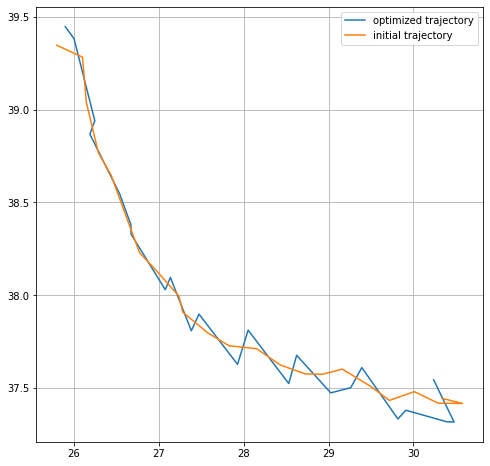

Visibility loss: 1.8526779413223267
L2 loss: 0.0006523299380205572
Vel loss: 0.0020254086703062057
Acc loss: 0.0003799183468800038
Jerk loss: 0.0006077903672121465
Trajectory visibility score: 67153.6015625

-----------------------------------

Optimization step took 0.024874210357666016 sec


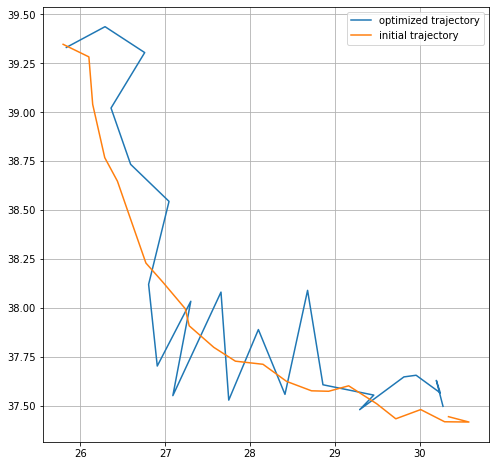

Visibility loss: 1.85427725315094
L2 loss: 0.00024354177003260702
Vel loss: 0.001686684787273407
Acc loss: 0.0002931086637545377
Jerk loss: 0.0003313132037874311
Trajectory visibility score: 67095.6875

-----------------------------------

Optimization step took 0.027443885803222656 sec


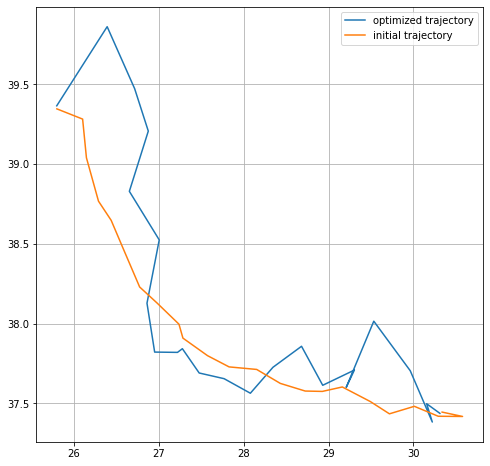

Visibility loss: 1.8544403314590454
L2 loss: 0.00012922132737003267
Vel loss: 0.0015995170688256621
Acc loss: 0.00032289157388731837
Jerk loss: 0.00046327721793204546
Trajectory visibility score: 67089.78125

-----------------------------------

Optimization step took 0.03681612014770508 sec


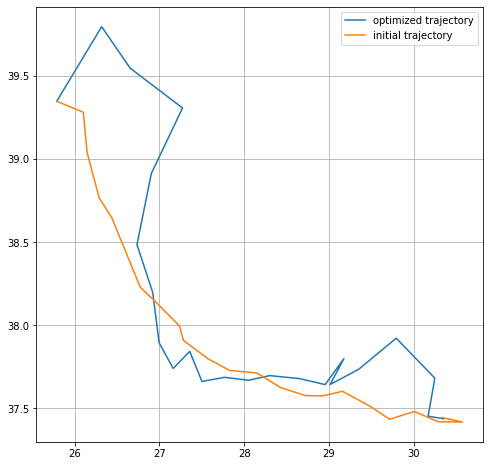

Visibility loss: 1.8578382730484009
L2 loss: 0.00010008649405790493
Vel loss: 0.001577823655679822
Acc loss: 0.00023327776580117643
Jerk loss: 0.0003039577277377248
Trajectory visibility score: 66967.078125

-----------------------------------

Optimization step took 0.040117502212524414 sec


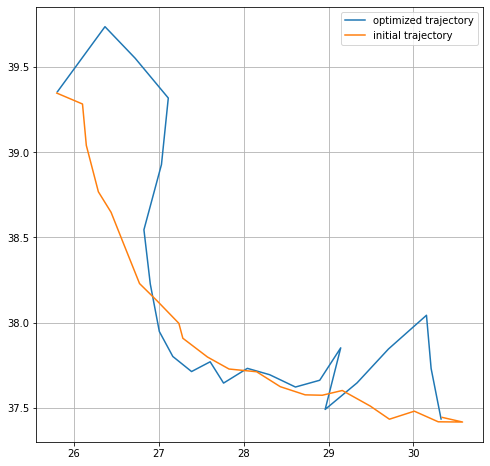

Visibility loss: 1.8625613451004028
L2 loss: 0.00015160262410063297
Vel loss: 0.0014044963754713535
Acc loss: 0.0002496948291081935
Jerk loss: 0.0002836171770468354
Trajectory visibility score: 66797.265625

-----------------------------------

Optimization step took 0.036402225494384766 sec


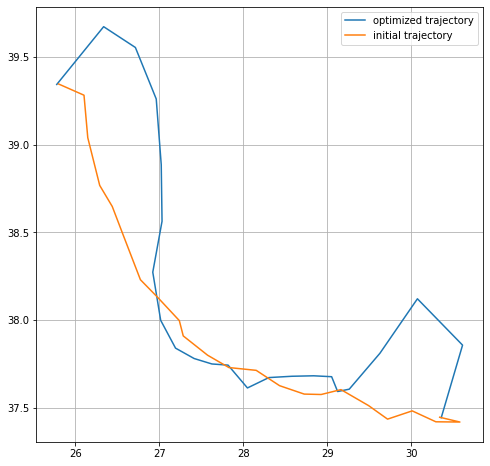

Visibility loss: 1.8696954250335693
L2 loss: 9.90221815300174e-05
Vel loss: 0.0012274922337383032
Acc loss: 0.00017156527610495687
Jerk loss: 0.00024088322243187577
Trajectory visibility score: 66542.390625

-----------------------------------

Optimization step took 0.0250699520111084 sec


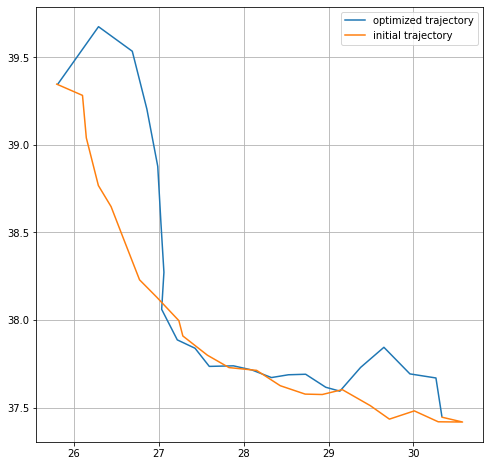

Visibility loss: 1.8705312013626099
L2 loss: 6.806008605053648e-05
Vel loss: 0.0011421118397265673
Acc loss: 0.00024499083519913256
Jerk loss: 0.00044118723599240184
Trajectory visibility score: 66512.65625

-----------------------------------

Optimization step took 0.024960756301879883 sec


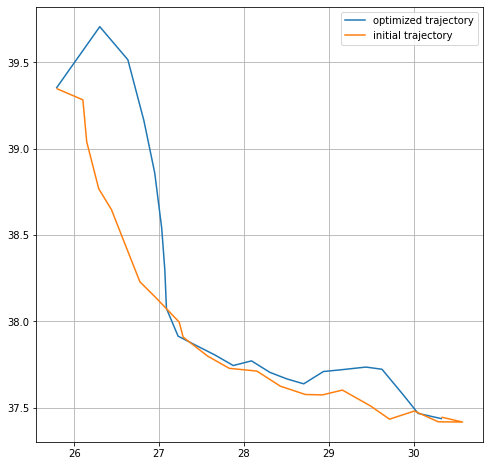

Visibility loss: 1.8688817024230957
L2 loss: 5.991484795231372e-05
Vel loss: 0.0011356694158166647
Acc loss: 0.00018134449783246964
Jerk loss: 0.00023601457360200584
Trajectory visibility score: 66571.359375

-----------------------------------

Optimization step took 0.025192737579345703 sec


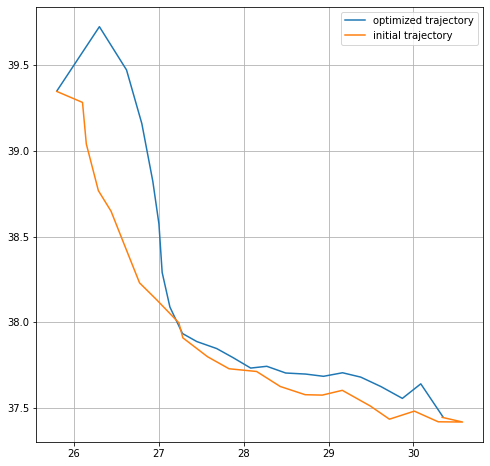

Visibility loss: 1.8696773052215576
L2 loss: 5.7816694607026875e-05
Vel loss: 0.0011100464034825563
Acc loss: 0.00016583350952714682
Jerk loss: 0.0002255292347399518
Trajectory visibility score: 66543.03125

-----------------------------------

Optimization step took 0.02472400665283203 sec


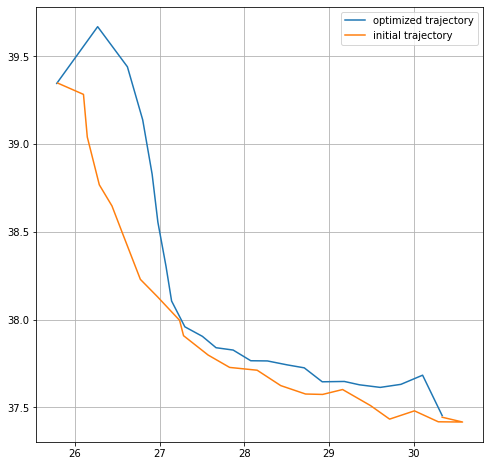

In [9]:
import time
from collections import deque


log = {}
for key in model.loss:
  log[key] = deque()

# Run optimization loop
traj_0 = np.asarray(traj_wps)

loop = tqdm(range(100))
for i in loop:
    t0 = time.time()
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()
    t1 = time.time()

    if i % 10 == 0:
        print(f"Visibility loss: {model.loss['vis']}")
        print(f"L2 loss: {model.loss['l2']}")
        print(f"Vel loss: {model.loss['vel']}")
        print(f"Acc loss: {model.loss['acc']}")
        print(f"Jerk loss: {model.loss['jerk']}")
        print(f"Trajectory visibility score: {torch.sum(model.rewards)}")
        print("\n-----------------------------------\n")
        print(f"Optimization step took {t1 - t0} sec")

        # Logging
        for key in model.loss:
            log[key].append(model.loss[key])
        
        traj = model.traj.detach().cpu().numpy()

        plt.figure(figsize=(8, 8))
        plt.grid()
        plt.plot(traj[:, 0], traj[:, 1], label='optimized trajectory')
        plt.plot(traj_0[:, 0], traj_0[:, 1], label='initial trajectory')
        plt.legend()
        plt.show();

# Losses

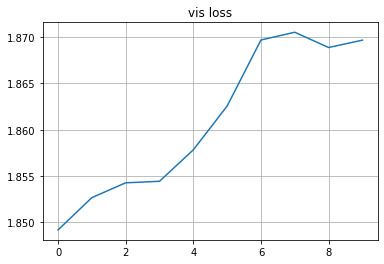

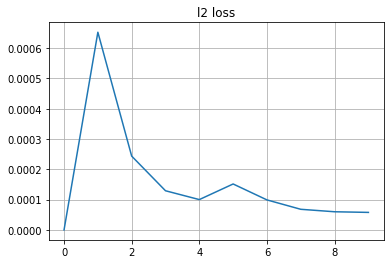

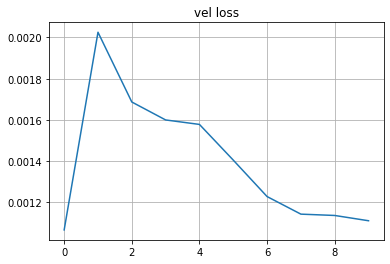

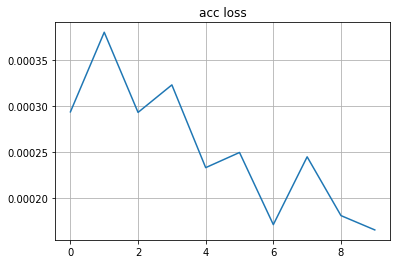

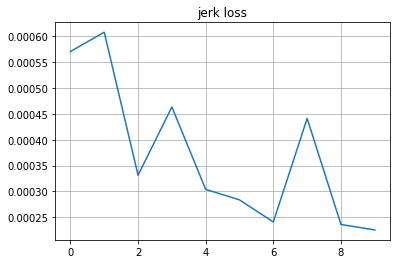

In [10]:
for key in log:
    plt.figure()
    plt.title(f"{key} loss")
    plt.plot(log[key])
    plt.grid()
    plt.show()

## Trajectory curvature calculation

The curvature is calculated using Menger's formula:

<img src="curvature_calculation_menger.png">

Reference: https://en.wikipedia.org/wiki/Menger_curvature#Definition

Area of a traingle, formed by 3 points is calculated as follows:

<img src="./traingle_square_from3_points.png">

Reference: https://math.stackexchange.com/questions/128991/how-to-calculate-the-area-of-a-3d-triangle

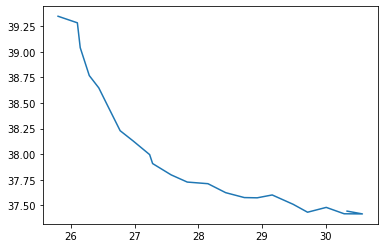

In [33]:
plt.plot(np.asarray(traj_wps)[:, 0], np.asarray(traj_wps)[:, 1]);

In [35]:
# computing curvature at i-th waypoint (i.e. traj_wps[i])
K_traj = 0.0
for i in range(1, len(traj_wps)-1):
    p1, p2, p3 = torch.as_tensor(traj_wps[i-1]), torch.as_tensor(traj_wps[i]), torch.as_tensor(traj_wps[i+1])

    AB = p1 - p2
    AC = p3 - p2

    # area of the triangle
    S = 0.5 *torch.sqrt((AB[1]*AC[2] - AB[2]*AC[1])**2 + (AB[2]*AC[0] - AB[0]*AC[2])**2 + (AB[0]*AC[1] - AB[1]*AC[0])**2)
    
    # curvature
    k = 4*S / (torch.linalg.norm(p1-p2) * torch.linalg.norm(p2-p3) * torch.linalg.norm(p3-p1))
    K_traj += k
K_traj = K_traj/(len(traj_wps)-2)

print(f"Average trajectory curvature: {K_traj}")

Average trajectory curvature: 1.5274107456207275
